### Практическое задание к уроку 3
Определите AUC_ROC и AUC_PR для модели логистической регрессии на тестовой выборке. Используйте реализацию модели в виде класса и функцию confusion, чтобы рассчитать TPR, FPR, precision, recal для различных порогов вероятности.  
Дополнительное задание(не обязательно): Получите такие же характеристики для линейной регрессии и сравните две модели.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from regressions import linear_regression, logistic_regression
from sklearn import datasets
from matplotlib.colors import ListedColormap

%matplotlib inline

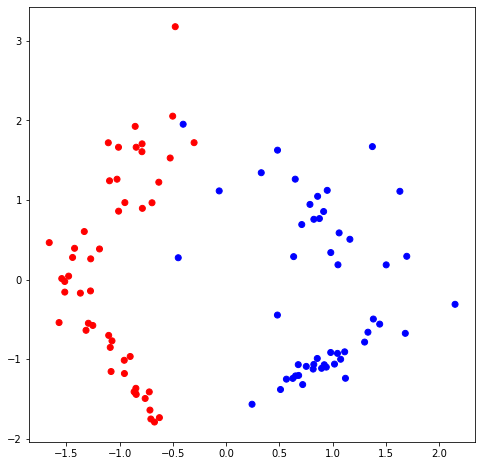

In [2]:
# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

In [3]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (70, 2)
Размер массива признаков тестовой выборки (30, 2)
Размер массива ответов для обучающей выборки (70,)
Размер массива ответов для тестовой выборки (30,)


In [4]:
mod = logistic_regression()
mod.fit(X_train, y_train)
y_predicted_test = mod.predict(X_test)
y_predicted_train = mod.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {mod.w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[0.32398168 0.01226158]]
Точность на обучающей выборке: 97.143
Точность на тестовой выборке: 96.667


In [14]:
proba = np.unique(mod.predict_proba(X_test))
proba

array([0.37576184, 0.37743532, 0.38605073, 0.39329824, 0.39603114,
       0.42197009, 0.42581106, 0.43518686, 0.43566684, 0.43744861,
       0.43928215, 0.46380207, 0.46916467, 0.47141598, 0.47900766,
       0.51300754, 0.53516296, 0.53568316, 0.54206801, 0.54703978,
       0.55547788, 0.5605486 , 0.56403656, 0.56439493, 0.56901128,
       0.57091569, 0.57432516, 0.57928111, 0.58140373, 0.59967655])

In [82]:
import matplotlib.pyplot as plt
from numpy import trapz

class AUC_ROC_PR:
    
    def __init__(self, model):
        self.model = model
    
    def _confusion(self, X, Y, proba):
        TP, FP = np.zeros(len(proba), dtype=int), np.zeros(len(proba), dtype=int)
        FN, TN = np.zeros(len(proba), dtype=int), np.zeros(len(proba), dtype=int)
        for i, p in enumerate(proba):
            predicted = self.model.predict(X, p)
            TP[i] = np.sum(np.logical_and(predicted == 1, Y == 1))
            FP[i] = np.sum(np.logical_and(predicted == 1, Y == 0))
            FN[i] = np.sum(np.logical_and(predicted == 0, Y == 1))
            TN[i] = np.sum(np.logical_and(predicted == 0, Y == 0))
        return TP, FP, FN, TN
    
    def _FPR_TPR(self, TP, FP, FN, TN):
        FPR = FP / (FP + TN)
        TPR = TP / (TP + FN)
        FPR = np.flip(FPR)
        TPR = np.flip(TPR)
        # Добавление 0 или 1 при необходимости 
        if FPR[0] != 0 or TPR[0] != 0:
            FPR, TPR = np.concatenate([[0], FPR]), np.concatenate([[0], TPR])
        if FPR[-1] != 1 or TPR[-1] != 1:
            FPR, TPR = np.concatenate([FPR, [1.0]]), np.concatenate([TPR, [1.0]])
        return FPR, TPR
    
    def AUC_ROC(self, X, Y, show_curve=False):
        proba = np.unique(self.model.predict_proba(X))
        TP, FP, FN, TN = self._confusion(X, Y, proba)
        FPR, TPR = self._FPR_TPR(TP, FP, FN, TN)
        AUC_ROC = trapz(TPR, x = FPR, dx=0.1)
        if show_curve:
            plt.title('ROC curve')
            plt.ylim(0, 1.05)
            plt.xlabel('FPR')
            plt.ylabel('TPR')
            plt.grid()
            plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
            plt.plot(FPR, TPR)
        return AUC_ROC
    
    def _PR(self, TP, FP, FN):
        precision = TP[: -1] / (TP[: -1] + FP[: -1]) 
        recall  = TP / (TP + FN)
        precision = np.flip(precision)
        recall = np.flip(recall)
        return precision, recall[1:]
    
    def AUC_PR(self, X, Y, show_curve=False):
        proba = np.unique(self.model.predict_proba(X))
        TP, FP, FN, TN = self._confusion(X, Y, proba)
        precision, recall = self._PR(TP, FP, FN)
        AUC_PR = trapz(precision, x = recall, dx=0.1)
        if show_curve:
            plt.title('PR curve')
            plt.ylim(0, 1.05)
            plt.xlabel('recall')
            plt.ylabel('presision')
            plt.grid()
            plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
            plt.plot(recall, precision)        

In [83]:
auc_mod = AUC_ROC_PR(mod)

0.9955357142857143

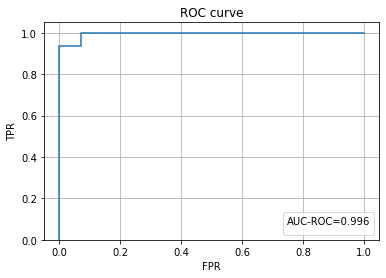

In [84]:
auc_mod.AUC_ROC(X_test, y_test, True)

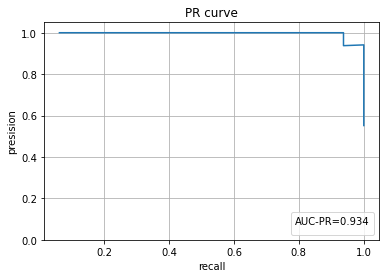

In [85]:
auc_mod.AUC_PR(X_test, y_test, True)

In [90]:
class logistic_regression_whth_AUC:

    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations = n_iterations
        self.eta = eta

    def _log_grad(self, X, target):
        m = X.shape[0]
        y = (2*target - 1)
        score = np.dot(X, self.w.T).flatten() + self.w0
        Z = -y/(m * (1 + np.exp(y * score)))
        grad = Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m

    def _optimize(self, X, target):
        for i in range(self.n_iterations):        
            grad_w, grad_w0 = self._log_grad(X, target)
            self.w = self.w - self.eta * grad_w
            self.w0 = self.w0 - self.eta * grad_w0

    def fit(self, X, target):
        self.w = np.zeros((1, X.shape[1]))
        self.w0 = 0
        self._optimize(X, target)

    def predict_proba(self, X):  
        # Рассчёт вероятности
        score = X.dot(self.w.T).flatten() + self.w0
        return 1 / (1 + np.exp(-score))

    def predict(self, X, thr=0.5):
        proba = self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba > thr] = 1
        y_predicted[proba <= thr] = 0
        return y_predicted

    def _confusion(self, X, target, proba):
        TP, FP = np.zeros(len(proba), dtype=int), np.zeros(len(proba), dtype=int)
        FN, TN = np.zeros(len(proba), dtype=int), np.zeros(len(proba), dtype=int)
        for i, p in enumerate(proba):
            predicted = self.predict(X, p)
            TP[i] = np.sum(np.logical_and(predicted == 1, target == 1))
            FP[i] = np.sum(np.logical_and(predicted == 1, target == 0))
            FN[i] = np.sum(np.logical_and(predicted == 0, target == 1))
            TN[i] = np.sum(np.logical_and(predicted == 0, target == 0))
        return TP, FP, FN, TN
    
    def _FPR_TPR(self, TP, FP, FN, TN):
        FPR = FP / (FP + TN)
        TPR = TP / (TP + FN)
        FPR = np.flip(FPR)
        TPR = np.flip(TPR)
        # Добавление 0 или 1 при необходимости 
        if FPR[0] != 0 or TPR[0] != 0:
            FPR, TPR = np.concatenate([[0], FPR]), np.concatenate([[0], TPR])
        if FPR[-1] != 1 or TPR[-1] != 1:
            FPR, TPR = np.concatenate([FPR, [1.0]]), np.concatenate([TPR, [1.0]])
        return FPR, TPR
    
    def AUC_ROC(self, X, target, show_curve=False):
        proba = self.predict_proba(X)
        TP, FP, FN, TN = self._confusion(X, target, proba)
        FPR, TPR = self._FPR_TPR(TP, FP, FN, TN)
        AUC_ROC = trapz(TPR, x = FPR, dx=0.1)
        if show_curve:
            plt.title('ROC curve')
            plt.ylim(0, 1.05)
            plt.xlabel('FPR')
            plt.ylabel('TPR')
            plt.grid()
            plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
            plt.plot(FPR, TPR)
        return AUC_ROC
    
    def _PR(self, TP, FP, FN):
        precision = TP[: -1] / (TP[: -1] + FP[: -1]) 
        recall  = TP / (TP + FN)
        precision = np.flip(precision)
        recall = np.flip(recall)
        return precision, recall[1:]
    
    def AUC_PR(self, X, target, show_curve=False):
        proba = self.predict_proba(X)
        TP, FP, FN, TN = self._confusion(X, target, proba)
        precision, recall = self._PR(TP, FP, FN)
        AUC_PR = trapz(precision, x = recall, dx=0.1)
        if show_curve:
            plt.title('PR curve')
            plt.ylim(0, 1.05)
            plt.xlabel('recall')
            plt.ylabel('presision')
            plt.grid()
            plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
            plt.plot(recall, precision)   

In [91]:
mod_auc = logistic_regression_whth_AUC()
mod_auc.fit(X_train, y_train)
y_predicted_test = mod_auc.predict(X_test)
y_predicted_train = mod_auc.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {mod_auc.w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[0.32398168 0.01226158]]
Точность на обучающей выборке: 97.143
Точность на тестовой выборке: 96.667


<ipython-input-90-5ecfbede7087>:77: RuntimeWarning: invalid value encountered in true_divide
  precision = TP[: -1] / (TP[: -1] + FP[: -1])


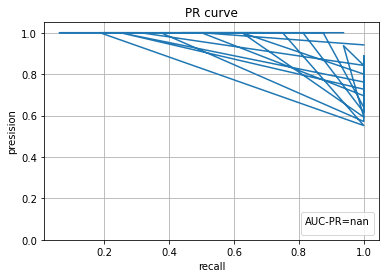

In [93]:
mod_auc.AUC_PR(X_test, y_test, True)